In [17]:
from pathlib import Path
import json

from zod import ZodDataset, ZodFrame, ZodFrames
from zod import AnnotationProject

from tqdm import tqdm

/home/tjhu78u/miniconda3/envs/zod/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
DATASET_DIR = "/home/tjhu78u/workspace/traffic_sign_detection/data"
VERSION = "full"


FILTER_FILE = "/home/tjhu78u/workspace/traffic_sign_detection/data/metadata/DE_ts.txt"

HEIGHT = 2168
WIDTH = 3848

BoxMode = 0  # XYXY_ABS = 0

ts_classes = [
    "unknown_traffic_sign",
]

In [19]:
zod_dataset = ZodFrames(DATASET_DIR, version=VERSION)

# build filter list
filter_file = Path(FILTER_FILE)

with open(filter_file, "r") as f:
    filter_list = [line.strip() for line in f.readlines()]
print(f"Loading {filter_file}\nKeep {len(filter_list)} driving logs")

Loading infos: 100000it [00:14, 6999.32it/s]


Loading /home/tjhu78u/workspace/traffic_sign_detection/data/metadata/DE_ts.txt
Keep 19492 driving logs


In [21]:
from matplotlib import pyplot as plt


def plot_bboxs_on_image(image: str, bboxs: list):
    plt.imshow(image)
    for bbox in bboxs:
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        rect = plt.Rectangle(
            (x1, y1),
            w,
            h,
            fill=False,
            color="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")
    plt.show()
    


(2168, 3848, 3)
[[1299, 1054, 1322, 1059], [1323, 1063, 1348, 1067], [2682, 921, 2736, 975], [1323, 1059, 1348, 1063], [1323, 1072, 1330, 1075], [1660, 969, 1714, 1025], [1299, 1067, 1322, 1071], [1299, 1063, 1322, 1067], [2770, 886, 2822, 944], [1323, 1067, 1348, 1072], [1299, 1071, 1322, 1076], [2597, 1053, 2610, 1066], [1299, 1059, 1322, 1063], [1299, 1076, 1322, 1080], [2534, 1048, 2560, 1081], [2785, 945, 2814, 1004], [1324, 1055, 1348, 1059]]


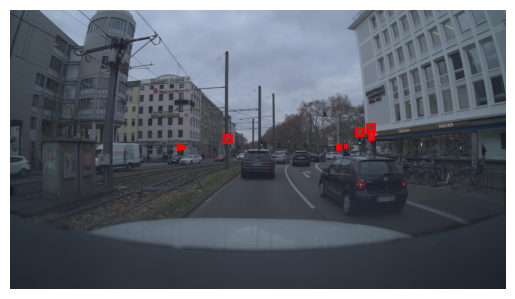

In [33]:
log = zod_dataset["002398"]

image = log.get_image()
print(image.shape)

ts_annos = log.get_annotation(AnnotationProject.TRAFFIC_SIGNS)
# print(ts_annos)

bboxs = []
for ts_anno in ts_annos:
    bbox = ts_anno.bounding_box.xyxy
    x1, y1, x2, y2 = [int(x) for x in bbox]
    bboxs.append([x1, y1, x2, y2])
print(bboxs)

plot_bboxs_on_image(image, bboxs)

In [ ]:
metadata_all = []
for log_id in tqdm(filter_list, total=len(filter_list)):

    log = zod_dataset[log_id]
    log_dir = Path(DATASET_DIR) / "single_frames" / log_id
    img_dir = log_dir / "camera_front_blur"
    img_fpath = list(img_dir.glob("*.jpg"))[0]
    img_abs_fpath = str(img_fpath.resolve())

    ts_annos = log.get_annotation(
        AnnotationProject.TRAFFIC_SIGNS
    )  # traffic sign list

    metadata_one = {
        "file_name": img_abs_fpath,
        "height": HEIGHT,
        "width": WIDTH,
        "image_id": log_id,
        "annotations": [],
    }

    for ts in ts_annos:
        bbox = ts.bounding_box.xyxy
        # convert bbox to pixel coordinates (ints), handling normalized boxes
        x1, y1, x2, y2 = [x for x in bbox]
        # x1 *= WIDTH
        # x2 *= WIDTH
        # y1 *= HEIGHT
        # y2 *= HEIGHT
        bbox = [int(round(v)) for v in (x1, y1, x2, y2)]

        bbox_mode_val = BoxMode.XYXY_ABS.value
        if ts.traffic_sign_class is None:
            ts_class = "unknown_traffic_sign"
        else:
            ts_class = ts.traffic_sign_class
            if ts_class not in ts_classes:
                ts_classes.append(ts_class)

        metadata_one["annotations"].append(
            {
                "bbox": bbox,
                "bbox_mode": bbox_mode_val,
                "category_id": ts_classes.index(ts_class),
            }
        )

    metadata_all.append(metadata_one)

print(f"Totally {len(metadata_all)} images")

# dump to json
with open("train.json", "w") as f:
    json.dump(metadata_all, f, indent=2, ensure_ascii=False)
    
with open("label.json", "w") as f:
    json.dump(ts_classes, f, indent=2)


In [1]:
import json
from matplotlib import pyplot as plt

In [2]:
metadata_fpath = "train.json"

with open(metadata_fpath, "r") as f:
    metadata = json.load(f)

print(len(metadata))

19492


In [3]:
idx = 0
sample = metadata[idx]
print(sample)

{'file_name': '/mnt/disk/data/public/zod/single_frames/000090/camera_front_blur/000090_india_2020-12-02T16:07:09.003549Z.jpg', 'height': 2168, 'width': 3848, 'image_id': '000090', 'annotations': [{'bbox': [2588, 1085, 2665, 1142], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [1925, 1098, 1934, 1104], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [2013, 1093, 2033, 1108], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [1917, 1097, 1924, 1102], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [1951, 1096, 1964, 1104], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [2542, 1092, 2561, 1111], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [1908, 1096, 1915, 1101], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [1902, 1095, 1907, 1100], 'bbox_mode': 0, 'category_id': 0}, {'bbox': [1897, 1089, 1903, 1094], 'bbox_mode': 0, 'category_id': 0}]}


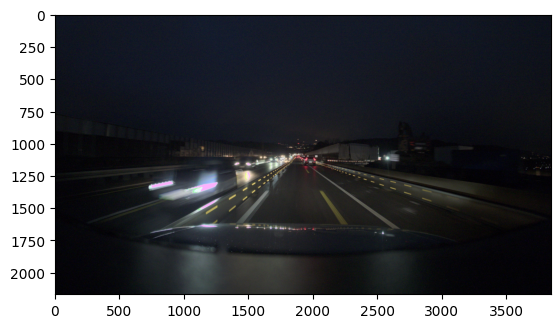

In [5]:
image_fpath = sample["file_name"]
image = plt.imread(image_fpath)
plt.imshow(image)

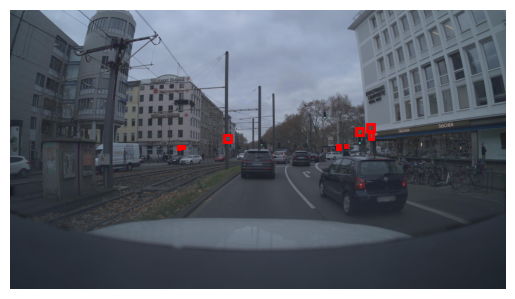

[[1299, 1055, 1323, 1060], [1324, 1064, 1348, 1068], [2683, 922, 2736, 976], [1324, 1059, 1348, 1063], [1323, 1072, 1330, 1076], [1660, 970, 1715, 1025], [1299, 1068, 1323, 1072], [1299, 1064, 1323, 1068], [2770, 887, 2822, 944], [1323, 1068, 1348, 1072], [1299, 1072, 1322, 1076], [2598, 1054, 2611, 1067], [1299, 1060, 1323, 1063], [1300, 1076, 1322, 1080], [2535, 1048, 2561, 1082], [2785, 946, 2815, 1004], [1324, 1055, 1349, 1059]]


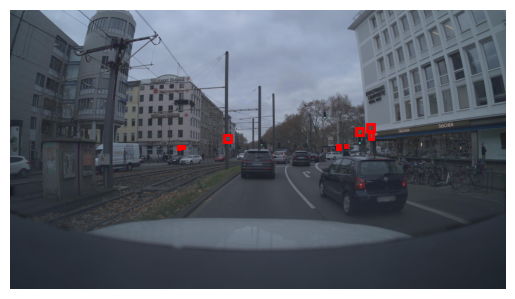

In [49]:
def plot_bboxs_on_image(image: str, bboxs: list):
    image = plt.imread(image)
    plt.imshow(image)
    for bbox in bboxs:
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        rect = plt.Rectangle(
            (x1, y1),
            w,
            h,
            fill=False,
            color="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")
    plt.show()


def plot_ts_on_image(data_info):
    image_fpath = data_info["file_name"]
    image = plt.imread(image_fpath)
    plt.imshow(image)
    for ann in data_info["annotations"]:
        bbox = ann["bbox"]
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        rect = plt.Rectangle(
            (x1, y1),
            w,
            h,
            fill=False,
            color="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)
    plt.axis("off")
    plt.show()


idx = 66
plot_ts_on_image(metadata[idx])
bboxs = [ann["bbox"] for ann in metadata[idx]["annotations"]]
print(bboxs)
plot_bboxs_on_image(metadata[idx]["file_name"], bboxs)